In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_breast_cancer

In [2]:
data = load_breast_cancer()
X_all, y_all = data.data, data.target

print("Dataset shape:", X_all.shape, "Labels shape:", y_all.shape)
print("Classes:", data.target_names)
print("Features:", data.feature_names[:5], "...")

Dataset shape: (569, 30) Labels shape: (569,)
Classes: ['malignant' 'benign']
Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness'] ...


In [3]:
def sigmoid(z):
    z = np.clip(z, -500, 500)   # avoid overflow
    return 1.0 / (1.0 + np.exp(-z))


def binary_cross_entropy(y_true, y_prob, w=None, l2_lambda=0.0):
    eps = 1e-12
    y_prob = np.clip(y_prob, eps, 1 - eps)
    n = y_true.shape[0]

    loss = -(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob)).mean()

    if w is not None and l2_lambda > 0.0:
        # exclude bias term (index 0) from regularization
        loss += (l2_lambda / (2 * n)) * np.sum(w[1:] ** 2)

    return loss


def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()


def precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0


def recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0


def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0.0

In [4]:
class StandardScaler:
    """
    Simple standardizer:
      x_std = (x - mean_) / scale_
    - Fit ONLY on training data, then apply to val/test.
    - Uses population std (ddof=0).
    - Guards against zero variance (scale_=1 for those cols).
    """
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=float)
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0, ddof=0)
        # Stops dividing by zero
        self.scale_ = np.where(self.scale_ == 0.0, 1.0, self.scale_)
        return self

    def transform(self, X):
        if self.mean_ is None or self.scale_ is None:
            raise RuntimeError("Call fit(X_train) before transform.")
        X = np.asarray(X, dtype=float)
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        return self.fit(X).transform(X)

    def inverse_transform(self, X_std):
        if self.mean_ is None or self.scale_ is None:
            raise RuntimeError("Scaler not fitted.")
        X_std = np.asarray(X_std, dtype=float)
        return X_std * self.scale_ + self.mean_

In [5]:
def stratified_split(X, y, rng, train_frac=0.6, val_frac=0.2):
    """
    Split dataset into stratified train/val/test subsets.
    Keeps class proportions consistent.
    """
    classes = np.unique(y)

    idx_train, idx_val, idx_test = [], [], []

    for c in classes:
        idx_c = np.where(y == c)[0]
        rng.shuffle(idx_c)

        n = len(idx_c)
        n_train = int(train_frac * n)
        n_val   = int(val_frac * n)

        idx_train.extend(idx_c[:n_train])
        idx_val.extend(idx_c[n_train:n_train + n_val])
        idx_test.extend(idx_c[n_train + n_val:])

    return np.array(idx_train), np.array(idx_val), np.array(idx_test)


# Example usage with numpy's Generator
rng = np.random.default_rng(42)

idx_train, idx_val, idx_test = stratified_split(X_all, y_all, rng)

X_train, y_train = X_all[idx_train], y_all[idx_train]
X_val,   y_val   = X_all[idx_val],   y_all[idx_val]
X_test,  y_test  = X_all[idx_test],  y_all[idx_test]

print("Splits:")
print("  Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Splits:
  Train: (341, 30) Val: (113, 30) Test: (115, 30)


In [6]:
class LogisticRegressionScratch:
    """
    Binary logistic regression trained with full-batch gradient descent.

    - Uses intercept column of ones (no separate b parameter).
    - L2 regularization on weights EXCLUDING the bias term.
    - Tracks train/val loss curves in self.history_.
    """

    def __init__(self, lr=0.1, n_iters=4000, l2_lambda=0.0, tol=1e-7, verbose=False):
        self.lr = float(lr)
        self.n_iters = int(n_iters)
        self.l2_lambda = float(l2_lambda)
        self.tol = float(tol)
        self.verbose = bool(verbose)

        self.w_ = None
        self.history_ = {"train_loss": [], "val_loss": []}

    @staticmethod
    def _add_intercept(X):
        # Add a column of ones as the first column.
        X = np.asarray(X, dtype=float)
        return np.c_[np.ones((X.shape[0], 1)), X]

    def _forward(self, X):
        # Compute logits and probabilities.
        Xb = self._add_intercept(X)
        z = Xb @ self.w_
        p = sigmoid(z)
        return Xb, p

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        X_train = np.asarray(X_train, dtype=float)
        y_train = np.asarray(y_train, dtype=float).ravel()
        n, d = X_train.shape

        # initialize weights to zeros
        self.w_ = np.zeros(d + 1, dtype=float)

        prev_loss = np.inf

        for it in range(self.n_iters):
            # forward
            Xb, p = self._forward(X_train)  # p in (0,1)

            # gradient (full-batch): (d+1,)
            # error = p - y; grad = Xb^T (p - y) / n
            error = p - y_train
            grad = (Xb.T @ error) / n

            # L2 regularization (exclude bias at index 0)
            if self.l2_lambda > 0.0:
                grad[1:] += (self.l2_lambda / n) * self.w_[1:]

            # update
            self.w_ -= self.lr * grad

            # bookkeeping: losses
            train_loss = binary_cross_entropy(y_train, p, w=self.w_, l2_lambda=self.l2_lambda)
            self.history_["train_loss"].append(train_loss)

            if X_val is not None and y_val is not None:
                _, p_val = self._forward(X_val)
                val_loss = binary_cross_entropy(y_val, p_val, w=self.w_, l2_lambda=self.l2_lambda)
                self.history_["val_loss"].append(val_loss)

            # simple convergence check on training loss
            if np.abs(prev_loss - train_loss) < self.tol:
                if self.verbose:
                    print(f"Early stop at iter={it}, train_loss={train_loss:.6f}")
                break
            prev_loss = train_loss

        return self

    def predict_proba(self, X):
        if self.w_ is None:
            raise RuntimeError("Model not fitted yet.")
        _, p = self._forward(X)
        return p

    def predict(self, X, threshold=0.5):
        p = self.predict_proba(X)
        return (p >= threshold).astype(int)

In [7]:
def plot_loss(history):
    """
    Plot training and (optional) validation loss curves stored in model.history_.
    """
    plt.figure()
    plt.plot(history["train_loss"], label="Train Loss")
    if "val_loss" in history and len(history["val_loss"]) > 0:
        plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Binary Cross-Entropy")
    plt.title("Training / Validation Loss")
    plt.legend()
    plt.show()

Train means (≈0): [-0.  0.  0.  0.  0.] ...
Train stds  (≈1): [1. 1. 1. 1. 1.] ...


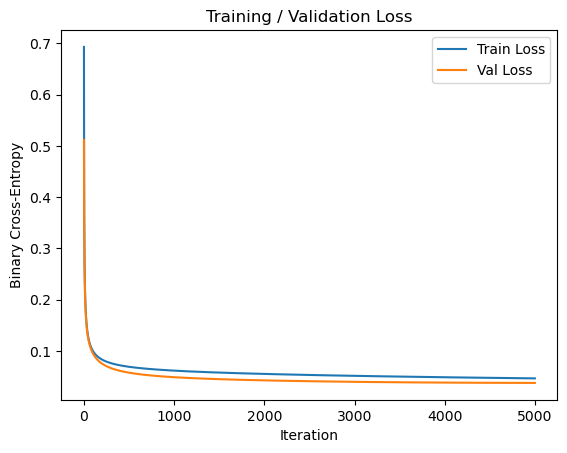

Final Train Loss: 0.046481
Final Val   Loss: 0.037619


In [8]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std   = scaler.transform(X_val)
X_test_std  = scaler.transform(X_test)

# Sanity check: train standardized features should have ~0 mean and ~1 std
print("Train means (≈0):", np.round(X_train_std.mean(axis=0)[:5], 4), "...")
print("Train stds  (≈1):", np.round(X_train_std.std(axis=0, ddof=0)[:5], 4), "...")

# Hyperparameters — adjust as needed
lr        = 0.1       # learning rate
n_iters   = 5000      # iterations
l2_lambda = 0.01      # L2 coefficient (0.0 disables regularization)
tol       = 1e-7      # early-stop tolerance

model = LogisticRegressionScratch(lr=lr, n_iters=n_iters, l2_lambda=l2_lambda, tol=tol, verbose=False)
model.fit(X_train_std, y_train, X_val=X_val_std, y_val=y_val)

# Plot loss curves
plot_loss(model.history_)

# Display final losses
final_train_loss = model.history_["train_loss"][-1]
final_val_loss   = model.history_["val_loss"][-1] if len(model.history_["val_loss"]) else np.nan
print(f"Final Train Loss: {final_train_loss:.6f}")
print(f"Final Val   Loss: {final_val_loss:.6f}")

In [9]:
def confusion_matrix_binary(y_true, y_pred):
    """
    [[TN, FP],
     [FN, TP]]
    """
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    return np.array([[tn, fp], [fn, tp]])

# Probabilities
p_train = model.predict_proba(X_train_std)
p_val   = model.predict_proba(X_val_std)
p_test  = model.predict_proba(X_test_std)

# Class predictions (threshold = 0.5)
yhat_train = (p_train >= 0.5).astype(int)
yhat_val   = (p_val   >= 0.5).astype(int)
yhat_test  = (p_test  >= 0.5).astype(int)

# Metrics
def print_metrics(split, y_true, y_pred):
    acc = accuracy(y_true, y_pred)
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{split} — Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")
    print("Confusion matrix [[TN, FP], [FN, TP]]:\n", confusion_matrix_binary(y_true, y_pred), "\n")

print_metrics("Train", y_train, yhat_train)
print_metrics("Val  ", y_val,   yhat_val)
print_metrics("Test ", y_test,  yhat_test)

Train — Acc: 0.9912 | Prec: 0.9862 | Rec: 1.0000 | F1: 0.9930
Confusion matrix [[TN, FP], [FN, TP]]:
 [[124   3]
 [  0 214]] 

Val   — Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Confusion matrix [[TN, FP], [FN, TP]]:
 [[42  0]
 [ 0 71]] 

Test  — Acc: 0.9652 | Prec: 0.9474 | Rec: 1.0000 | F1: 0.9730
Confusion matrix [[TN, FP], [FN, TP]]:
 [[39  4]
 [ 0 72]] 



In [10]:
print("Bias (theta_0):", model.w_[0])
print("Weights (theta_1..theta_d):")
print(model.w_[1:])

# First 5 test examples: probabilities and predicted classes
k = 5
probs_5 = p_test[:k]
preds_5 = yhat_test[:k]
y_5     = y_test[:k]

df_first5 = pd.DataFrame({
    "y_true": y_5,
    "p_hat": probs_5,
    "y_pred": preds_5
})
print("\nFirst 5 test examples (probabilities & classes):")
display(df_first5)

Bias (theta_0): -0.18079763086864858
Weights (theta_1..theta_d):
[-0.39270483 -0.64799645 -0.37628171 -0.54071024 -0.2257173   0.88455917
 -0.89005765 -1.12493369  0.54027314  0.26709357 -1.8147602   0.034186
 -0.68885471 -1.46886965 -0.19307274  1.47486223 -0.02776099 -0.79451811
  0.17824184  1.00587512 -1.14570413 -1.05486192 -0.84097709 -1.14561247
 -1.06646302  0.12404663 -0.92497681 -1.15860554 -1.03117958 -1.02100259]

First 5 test examples (probabilities & classes):


,y_true,p_hat,y_pred
0,0,2.227097e-06,0
1,0,1.381958e-04,0
2,0,2.294774e-12,0
3,0,2.683925e-07,0
4,0,2.649235e-05,0


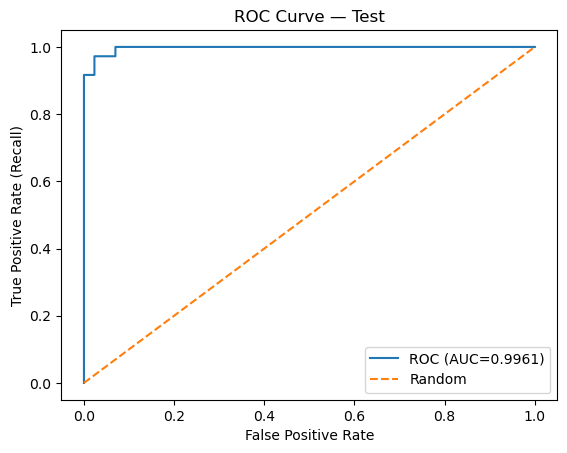

AUC (Test): 0.996124


In [11]:
def roc_curve_binary(y_true, y_prob, steps=1001):
    """
    Returns FPR, TPR arrays by sweeping threshold from 1 -> 0.
    """
    thresholds = np.linspace(1, 0, steps)
    tpr_list, fpr_list = [], []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix_binary(y_true, y_pred).ravel()
        tpr = tp / (tp + fn) if (tp + fn) else 0.0
        fpr = fp / (fp + tn) if (fp + tn) else 0.0
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return np.array(fpr_list), np.array(tpr_list)

def auc_trapezoid(x, y):
    """
    Area under curve via trapezoidal rule. Assumes x is sorted ascending.
    """
    order = np.argsort(x)
    x_sorted, y_sorted = x[order], y[order]
    return np.trapz(y_sorted, x_sorted)

# Compute on TEST split
fpr, tpr = roc_curve_binary(y_test, p_test, steps=2001)
auc_val = auc_trapezoid(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc_val:.4f})")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve — Test")
plt.legend()
plt.show()

print(f"AUC (Test): {auc_val:.6f}")